In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

In [2]:
preds = np.load("/scratch1/smaruj/test_human_fold0_AkitaV2/combined_pred_matrices.npy", allow_pickle=True)

In [3]:
targets = np.load("/scratch1/smaruj/test_human_fold0_AkitaV2/combined_target_matrices.npy", allow_pickle=True)

In [4]:
def plot_hexbin_accumulated(preds, targets, cell_type_idx, cell_type_name, save_path=None):
    # Concatenate all predictions and targets across the 725 test windows
    pred_vec_all = []
    target_vec_all = []
    
    for i in range(preds.shape[0]):
        # Flatten the 512x512 maps and concatenate
        pred_vec_all.append(preds[i, :, :, cell_type_idx].flatten())
        target_vec_all.append(targets[i, :, :, cell_type_idx].flatten())
    
    # Convert the list of arrays into a single array
    pred_vec_all = np.concatenate(pred_vec_all)
    target_vec_all = np.concatenate(target_vec_all)

    # Filter out NaN values
    mask = np.isfinite(pred_vec_all) & np.isfinite(target_vec_all)
    pred_vec_filtered = pred_vec_all[mask]
    target_vec_filtered = target_vec_all[mask]

    # Calculate Pearson correlation only on finite values
    corr, _ = pearsonr(pred_vec_filtered, target_vec_filtered) if len(pred_vec_filtered) > 0 else (np.nan, np.nan)

    # Create hexbin plot
    plt.figure(figsize=(7, 6))
    hb = plt.hexbin(pred_vec_filtered, target_vec_filtered, gridsize=50, cmap='viridis', bins='log')
    plt.colorbar(label='log10(frequency)')
    
    plt.xlabel(f'pred-{cell_type_name}')
    plt.ylabel(f'expt-{cell_type_name}')
    plt.title(f'corr: {corr:.2f}')
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', format="pdf")
    
    plt.show()

In [ ]:
# cell_types = ['mESC (Hsieh2019)', 'mESC (Bonev2017)', 'cortical neuron', 'neocortex cortical neuron', 'neural progenitor cell', 'neocortex neural progenitor cell']

In [5]:
cell_types = ["HFF", "H1hESC", "GM12878", "IMR90", "HCT116"]

Plotting for HFF...


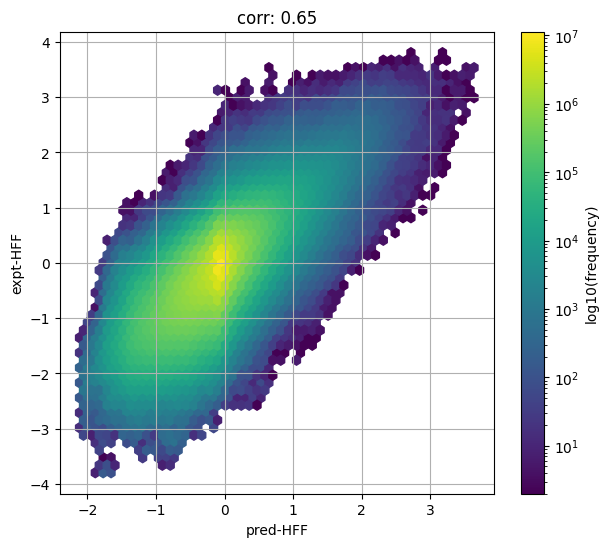

Plotting for H1hESC...


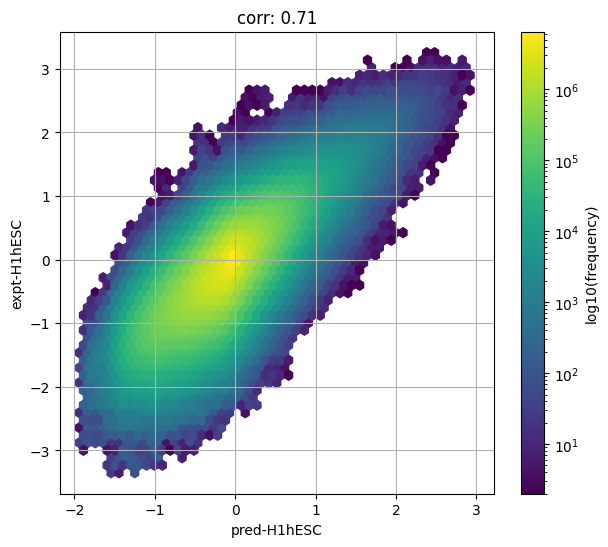

Plotting for GM12878...


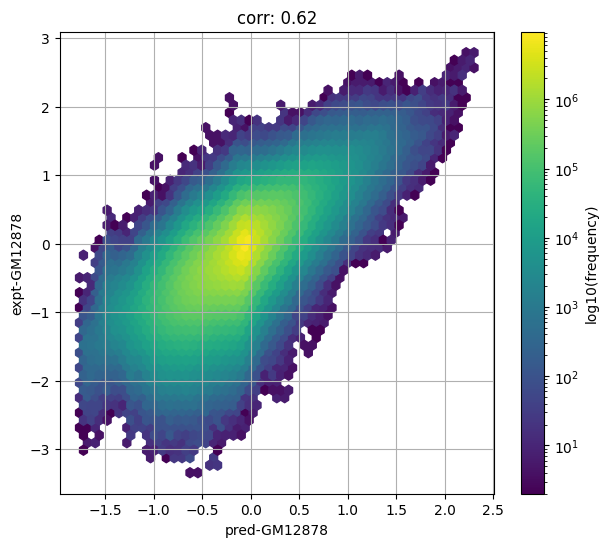

Plotting for IMR90...


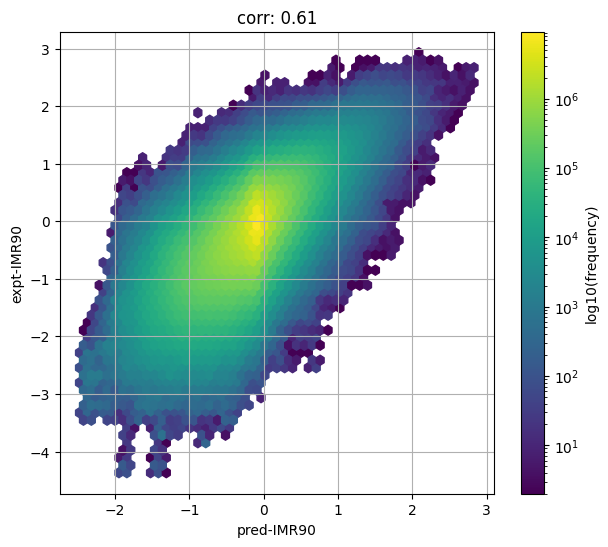

Plotting for HCT116...


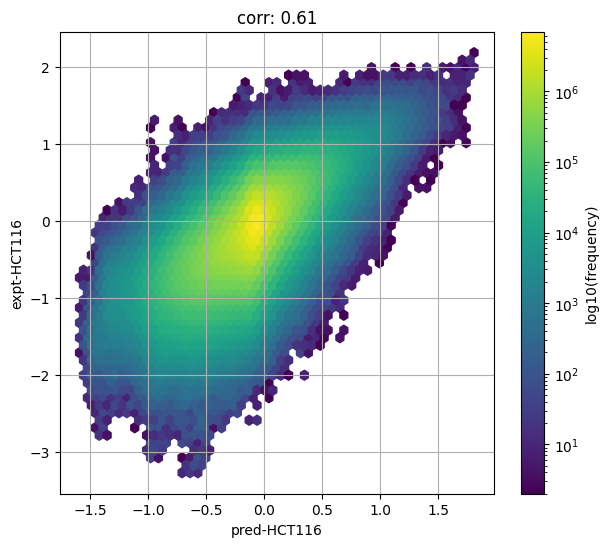

In [6]:
for idx, cell_type in enumerate(cell_types):
    print(f"Plotting for {cell_type}...")
    plot_hexbin_accumulated(preds, targets, cell_type_idx=idx, cell_type_name=cell_type, save_path=f"./plots_human/{cell_type}_corr.pdf")

In [7]:
def calculate_cell_type_correlation(matrix):
    num_cell_types = matrix.shape[-1]
    correlation_matrix = np.zeros((num_cell_types, num_cell_types))
    
    # Iterate over all pairs of cell types
    for i in range(num_cell_types):
        for j in range(i, num_cell_types):
            # Flatten the 512x512 maps for both cell types
            cell_type_i = matrix[:, :, :, i].flatten()
            cell_type_j = matrix[:, :, :, j].flatten()
            
            # Create a mask for valid (non-NaN) entries
            mask = ~np.isnan(cell_type_i) & ~np.isnan(cell_type_j)
            
            if np.any(mask):  # Check if there are any valid pairs
                # Calculate correlation between the two cell types using valid entries
                corr, _ = pearsonr(cell_type_i[mask], cell_type_j[mask])
            else:
                corr = np.nan  # Set correlation to NaN if no valid pairs
            
            correlation_matrix[i, j] = corr
            correlation_matrix[j, i] = corr  # Symmetric matrix
    
    return correlation_matrix

In [8]:
# Function to calculate average correlations between cell types
def average_cell_type_correlations(matrix):
    num_cell_types = matrix.shape[-1]
    
    # Initialize matrix to accumulate correlations across all windows
    corr_sum = np.zeros((num_cell_types, num_cell_types))
    
    # Iterate over all windows
    for i in range(matrix.shape[0]):
        # Calculate correlation matrix for current window
        corr = calculate_cell_type_correlation(matrix[i:i+1])
        
        # Accumulate the correlations
        corr_sum += corr
    
    # Average correlations over all windows
    corr_avg = corr_sum / matrix.shape[0]
    
    return corr_avg

In [21]:
# Function to plot heatmap of correlations
def plot_heatmap(corr_matrix, title, cell_type_names, save_path=None):
    plt.figure(figsize=(8, 6))
    
    mask = np.tril(np.ones_like(corr_matrix, dtype=bool))
    
    # vmin = np.min(corr_matrix)
    # vmax = np.max(corr_matrix)
    
    vmin = 0.11
    vmax = 0.32
    
    # Create the heatmap
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis', 
                vmin=vmin, vmax=vmax, mask=mask, cbar_kws={"shrink": .8},
                xticklabels=cell_type_names, yticklabels=cell_type_names)
    
    plt.title(title)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', format="pdf")
    
    plt.show()

In [10]:
# Calculate the average correlations for preds
pred_corr_avg = average_cell_type_correlations(preds)

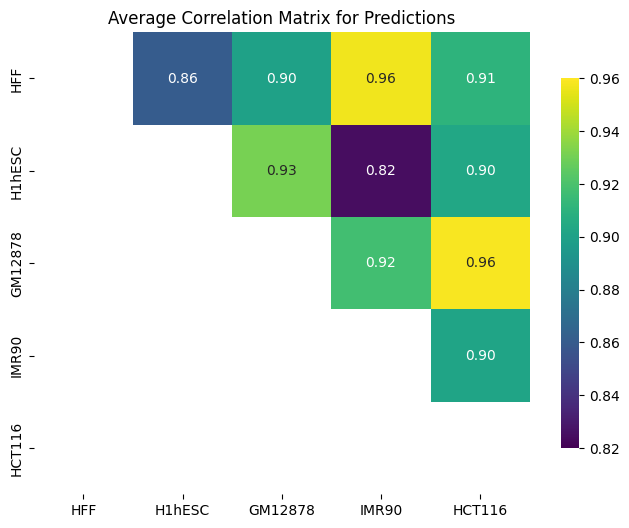

In [13]:
plot_heatmap(pred_corr_avg, "Average Correlation Matrix for Predictions", cell_type_names=cell_types, save_path="./plots_human/predictions_cell_type_corr.pdf")

In [14]:
del pred_corr_avg

In [15]:
# Calculate the average correlations for preds
targ_corr_avg = average_cell_type_correlations(targets)

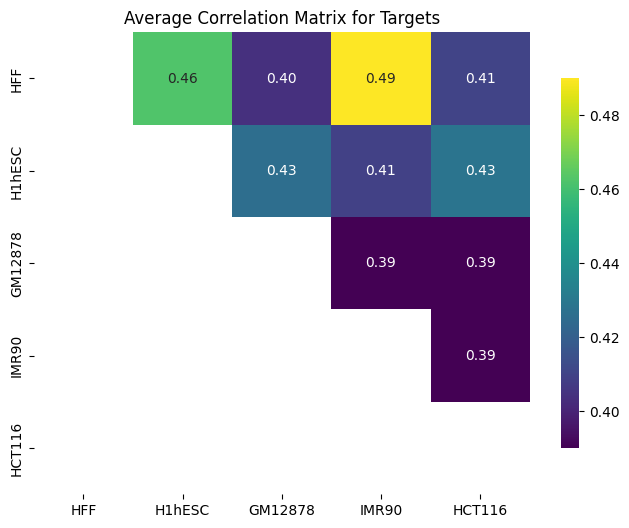

In [17]:
plot_heatmap(targ_corr_avg, "Average Correlation Matrix for Targets", cell_type_names=cell_types, save_path="./plots_human/targets_cell_type_corr.pdf")

In [18]:
del targ_corr_avg

In [19]:
def calculate_cell_type_differences_and_correlations(preds, targets):
    num_cell_types = preds.shape[3]
    correlations = np.zeros((num_cell_types, num_cell_types))  # Store correlations between differences

    for i in range(num_cell_types):
        for j in range(num_cell_types):
            # Calculate differences between cell types i and j for preds and targets
            preds_diff = preds[:, :, :, i] - preds[:, :, :, j]  # Difference between predictions
            targets_diff = targets[:, :, :, i] - targets[:, :, :, j]  # Difference between targets

            # Flatten the differences for correlation calculation
            preds_diff_flat = preds_diff.reshape(preds_diff.shape[0], -1)
            targets_diff_flat = targets_diff.reshape(targets_diff.shape[0], -1)

            # Compute the correlation only for finite values
            mask = np.isfinite(preds_diff_flat) & np.isfinite(targets_diff_flat)
            if np.any(mask):  # Check if there are any valid values
                corr, _ = pearsonr(preds_diff_flat[mask], targets_diff_flat[mask])
                correlations[i, j] = corr
            else:
                correlations[i, j] = np.nan  # No valid values to compute correlation

    return correlations

In [20]:
diff_corr = calculate_cell_type_differences_and_correlations(preds, targets)

/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


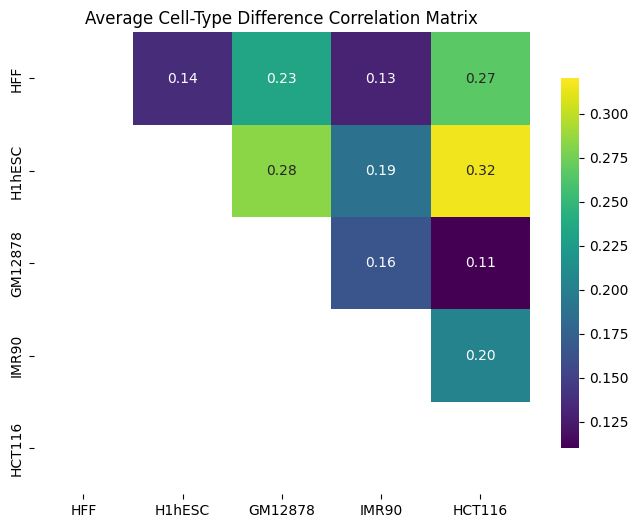

In [22]:
plot_heatmap(diff_corr, "Average Cell-Type Difference Correlation Matrix", cell_type_names=cell_types, save_path="./plots_human/cell_type_differences_corr.pdf")